# Lecture 16: Natural Language Processing II

CSCI 1360E: Foundations for Informatics and Analytics

## Overview and Objectives

Last week, we introduced the concept of natural language processing, and in particular the "bag of words" model for representing and quantifying text for later analysis. In this lecture, we'll expand on those topics, including some additional preprocessing and text representation methods. By the end of this lecture, you should be able to

 - Implement several preprocessing techniques like stemming, stopwords, and minimum counts
 - Understand the concept of *feature vectors* in natural language processing
 - Compute inverse document frequencies to up or down-weight term frequencies

## Part 1: Feature Vectors

The "bag of words" model: why do we do it? what does it give us?

**It's a way of representing documents in a format that is convenient and amenable to sophisticated analysis.**

You're interested in blogs. Specifically, you're interested in how blogs link to each other. Do politically-liberal blogs tend to link to politically-conservative blogs, and vice versa? Or do they mostly link to themselves?

Imagine you have a list of a few hundred blogs. To get their political leanings, you'd need to analyze the blogs and see how similar they are.

To do that, you need some notion of *similarity*...

**We need to be able to represent the blogs as *feature vectors*.**

If you can come up with a quantitative representation of your "thing" of interest, then you can compare it to other things in a similar quantitative representation format.

The bag-of-words model is just one way of turning a document into a **feature vector** that can be used in analysis. By considering each blog to be a single document, you can therefore convert each blog to its own bag-of-words and compare them directly.

(in fact, this has actually been done)

![blogs](Lecture16/politicalblogs.jpg)

http://waxy.org/2008/10/memeorandum_colors/

![featurevector](Lecture16/F_space.png)

If you have some data point $\vec{x}$ that is an $n$-dimensional vector (pictured above: a three-dimensional vector), each dimension is a single feature.

(*Hint*: what does this correspond to with NumPy arrays?)

Therefore, a bag-of-words model is just a way of **representing a document as a vector**, where each dimension is the count of one specific word!

Yes--a single dimension per word. That means, for a document with hundreds of thousands of unique words, the document's corresponding feature vector (courtesy of the bag-of-words representation) has **hundreds of thousands of dimensions.**

![wordvector](Lecture16/bowm.jpg)

Pictured above are three separate documents, and the number of times each of the words appears is given by the height of the histogram bar. **Stare at this until you get some understanding of what's happening--**these are three documents that share the same words (as you can see, they have the same x-axes), but what differs are the *relative heights of the bars*, meaning they have different *values* along the x-axes.

Of course there are other ways of representing documents as vectors, but bag-of-words is the *easiest*.

## Part 2: Text Preprocessing

What is "preprocessing"?

Name some preprocessing techniques with text we've covered!

 - Lower case (or upper case) everything
 - Split into single words
 - Remove trailing whitespace (spaces, tabs, newlines)

There are a few more that can be very powerful.

To start, let's go back to the *Alice in Wonderland* example from the previous lecture, but this time, we'll add a few more books for comparison:

 - [*Pride and Prejudice*](https://www.gutenberg.org/ebooks/1342), by Jane Austen
 - [*Frankenstein*](https://www.gutenberg.org/ebooks/84), by Mary Shelley
 - [*Beowulf*](https://www.gutenberg.org/ebooks/16328), by Lesslie Hall
 - [*The Adventures of Sherlock Holmes*](https://www.gutenberg.org/ebooks/1661), by Sir Arthur Conan Doyle
 - [*The Adventures of Tom Sawyer*](https://www.gutenberg.org/ebooks/74), by Mark Twain
 - [*The Adventures of Huckleberry Finn*](https://www.gutenberg.org/ebooks/76), by Mark Twain

Hopefully this variety should give us a good idea what we're dealing with!

First, we'll read all the books' raw contents into a dictionary.

In [1]:
books = {}  # We'll use a dictionary to store all the text from the books.
files = ['Lecture16/alice.txt',
         'Lecture16/pride.txt',
         'Lecture16/frank.txt',
         'Lecture16/bwulf.txt',
         'Lecture16/holmes.txt',
         'Lecture16/tom.txt',
         'Lecture16/finn.txt']

for f in files:
    # This weird line just takes the part of the filename between the "/" and "." as the dict key.
    prefix = f.split("/")[-1].split(".")[0]
    try:
        with open(f, "r", encoding = "ISO-8859-1") as descriptor:
            books[prefix] = descriptor.read()
    except:
        print("File '{}' had an error!".format(f))
        books[prefix] = None

In [2]:
# Here you can see the dict keys (i.e. the results of the weird line of code in the last cell)
print(books.keys())

dict_keys(['alice', 'pride', 'frank', 'bwulf', 'holmes', 'tom', 'finn'])


Just like before, let's go ahead and lower case everything, strip out whitespace, then count all the words.

In [3]:
def preprocess(book):
    # First, lowercase everything.
    lower = book.lower()
    
    # Second, split into lines.
    lines = lower.split("\n")
    
    # Third, split each line into words.
    words = []
    for line in lines:
        words.extend(line.strip().split(" "))

    # That's it!
    return count(words)

In [4]:
from collections import defaultdict # Our good friend from the last lecture, defaultdict!

def count(words):
    # This function takes a list of words as input, and counts them all up.
    counts = defaultdict(int)
    for w in words:
        counts[w] += 1
    return counts

In [5]:
# Finally, let's loop through our books and count
# all the words that show up!

counts = {}
for k, v in books.items():
    counts[k] = preprocess(v)

Let's see how our basic preprocessing techniques from the last lecture worked out.

In [6]:
from collections import Counter

def print_results(counts):
    for key, bag_of_words in counts.items():
        word_counts = Counter(bag_of_words) # Remember "Counter"?
        mc_word, mc_count = word_counts.most_common(1)[0]
        print("'{}': {} unique words; most common word '{}' appeared {} times."
              .format(key, len(bag_of_words.keys()), mc_word, mc_count))
print_results(counts)

'alice': 5582 unique words; most common word 'the' appeared 1777 times.
'pride': 13128 unique words; most common word 'the' appeared 4479 times.
'frank': 11702 unique words; most common word 'the' appeared 4327 times.
'bwulf': 11024 unique words; most common word '' appeared 3497 times.
'holmes': 14544 unique words; most common word 'the' appeared 5704 times.
'tom': 13445 unique words; most common word 'the' appeared 3907 times.
'finn': 13839 unique words; most common word 'and' appeared 6109 times.


Yeesh.

Not only are the most common words among the most boring ("the"? "and"?), but there are occasions where the most common word isn't even a word, but rather a blank space. (How do you think that could happen?)

Let's take a quick step back and think about the code we just saw.

 - The **`preprocess`** function takes a single book string as input and does some preprocessing: it lowercases everything so it's all the same case, it splits up the string into single words, and it adds all these words to one big list.

 - We also have a **`count`** function, which takes a list of words (output from `preprocess`) and counts everything up into a dictionary (the keys are unique words, the values how many times those words appear in the book). 

 - Finally, we have a block of code that loops over all our books and runs these two functions on each of them, building dictionaries of word counts. These are fed into **`print_results`** so that we can see 1) the number of unique words in each book, and 2) the most common word in each book.

We're going to repeat this process for the rest of the lecture, slowly upgrading the **`preprocess`** function so that the final result (top words for each book) become more meaningful and indicative of the books' contents. **If you had trouble following, please go back over the code again with these points in mind.**

### Stop words

A great first step is to implement stop words. (I used [this list of 319 stop words](http://xpo6.com/list-of-english-stop-words/))

In [7]:
# This code just reads in the words from a stoplist file
# and adds them to a list we can use later.
with open("Lecture16/stopwords.txt", "r") as f:
    lines = f.read().split("\n")
    stopwords = [w.strip() for w in lines]
print(stopwords[:5])

['a', 'about', 'above', 'across', 'after']


We'll now use the words in the `stopwords` list to eliminate words from our books (remember: we consider "stop words" to be meaningless to the overall semantics of the text; go back to the previous lecture if you need a refresher on stop words).

Now we'll augment our `preprocess` function to include stop word processing.

In [8]:
def preprocess_v2(book, stopwords):  # Note the "_v2"--this is a new function!
    # First, lowercase everything.
    lower = book.lower()
    
    # Second, split into lines.
    lines = lower.split("\n")
    
    # Third, split each line into words.
    words = []
    for line in lines:
        tokens = line.strip().split(" ")
        
        ### NEW CODE HERE!
        # Check for stopwords.
        for t in tokens:
            if t in stopwords: continue  # This "continue" SKIPS the stopword entirely!
            words.append(t)

    # That's it!
    return count(words)

Now let's see what we have!

In [9]:
# Same code as before--count the words in the books, but
# this time the stopwords will be filtered out per the
# new code in the preprocess_v2() function.
counts = {}
for k, v in books.items():
    counts[k] = preprocess_v2(v, stopwords)
    
print_results(counts)

'alice': 5348 unique words; most common word '' appeared 1178 times.
'pride': 12858 unique words; most common word '' appeared 2474 times.
'frank': 11440 unique words; most common word '' appeared 3413 times.
'bwulf': 10781 unique words; most common word '' appeared 3497 times.
'holmes': 14278 unique words; most common word '' appeared 2750 times.
'tom': 13176 unique words; most common word '' appeared 2284 times.
'finn': 13589 unique words; most common word '' appeared 2739 times.


Errr... this seems even worse! What's with the `''` word?! What could we try next?

### Minimum length

Our problem with "words" that are just blank strings `''` is that 
 1. Text is weird, and 
 2. We haven't told Python that we don't care about super-short "words" (that aren't really words)

We can get around this by adding another filtering step in our preprocess function: drop any word that has fewer than a certain number of characters.

Put another way: **ignore words under a certain length.**

Here's another new preprocessing function, this time enforcing a minimum word length of 3 (anything less than that is ignored the same way we ignore stop words).

In [10]:
def preprocess_v3(book, stopwords):  # We've reached "_v3"!
    # First, lowercase everything.
    lower = book.lower()
    
    # Second, split into lines.
    lines = lower.split("\n")
    
    # Third, split each line into words.
    words = []
    for line in lines:
        tokens = line.strip().split(" ")
        
        # Check for stopwords.
        for t in tokens:
            ### NEW CODE HERE! The "or" and everything after
            if t in stopwords or len(t) <= 2: continue # Skip stopwords OR words with length under 2
            words.append(t)

    # That's it!
    return count(words)

Maybe this will be better?

In [11]:
# Same word-counting again, this time using 
# preprocess_v3 to enforce both stopwords
# and minimum word length.
counts = {}
for k, v in books.items():
    counts[k] = preprocess_v3(v, stopwords)
    
print_results(counts)

'alice': 5315 unique words; most common word 'said' appeared 421 times.
'pride': 12777 unique words; most common word 'mr.' appeared 766 times.
'frank': 11384 unique words; most common word 'me,' appeared 147 times.
'bwulf': 10669 unique words; most common word 'beowulf' appeared 112 times.
'holmes': 14224 unique words; most common word 'said' appeared 448 times.
'tom': 13122 unique words; most common word 'tom' appeared 461 times.
'finn': 13540 unique words; most common word 'got' appeared 603 times.


Ooh! Definite improvement! Though clearly, punctuation is getting in the way; you can see it in at least two of the top words in the list above.

We spoke last time about how removing punctuation could be a little dangerous; what if the punctuation is inherent to the meaning of the word (i.e., a contraction)? 

Here, we'll compromise a little: we'll get the "easy" punctuation, like exclamation marks, periods, and commas, and leave the rest.

In our fourth version of the preprocess function, we've added a check for punctuation.

In [12]:
def preprocess_v4(book, stopwords):
    # First, lowercase everything.
    lower = book.lower()
    
    # Second, split into lines.
    lines = lower.split("\n")
    
    # Third, split each line into words.
    words = []
    for line in lines:
        tokens = line.strip().split(" ")
        
        # Check for stopwords.
        for t in tokens:

            ### NEW CODE HERE! This whole "if" statement.
            # Cut off any end-of-sentence punctuation.
            if t.endswith(",") or t.endswith("!") or t.endswith(".") or \
                    t.endswith(":") or t.endswith(";") or t.endswith("?"):
                t = t[:-1]  # This says: take everything except the last letter

            if t in stopwords or len(t) <= 2: continue
            words.append(t)

    # That's it!
    return count(words)

Alright, let's check it out again.

In [13]:
# Same thing AGAIN, this time with preprocess_v4
# to know out commas, exclamation marks, periods,
# colons, and semicolons.
counts = {}
for k, v in books.items():
    counts[k] = preprocess_v4(v, stopwords)
    
print_results(counts)

'alice': 4023 unique words; most common word 'said' appeared 456 times.
'pride': 8263 unique words; most common word 'elizabeth' appeared 587 times.
'frank': 7733 unique words; most common word 'myself' appeared 133 times.
'bwulf': 8497 unique words; most common word 'beowulf' appeared 156 times.
'holmes': 10511 unique words; most common word 'said' appeared 484 times.
'tom': 9807 unique words; most common word 'tom' appeared 611 times.
'finn': 9742 unique words; most common word 'says' appeared 628 times.


Now we're getting somewhere! But this introduces a new concept--in looking at this list, wouldn't you say that "says" and "said" are probably, semantically, more or less the same word?

### Stemming

Stemming is the process by which we convert words with similar meaning into the same word, so their similarity is reflected in our analysis. Words like "imaging" and "images", or "says" and "said" should probably be considered the same thing.

To do this, we'll need an external Python package: the Natural Language Toolkit, or NLTK. (it's installed on JupyterHub, so go ahead and play with it!)

[NLTK](https://www.nltk.org/) has a ton of really interesting stuff that goes way beyond the scope of this lecture. For our purposes, though, we're just going to use its "stemming" capabilities.

In [14]:
import nltk # This package!

def preprocess_v5(book, stopwords):
    lower = book.lower()
    lines = lower.split("\n")
    
    # Create the stemmer.
    stemmer = nltk.stem.SnowballStemmer('english')

    words = []
    for line in lines:
        tokens = line.strip().split(" ")
        
        for t in tokens:
            if t.endswith(",") or t.endswith("!") or t.endswith(".") or \
                    t.endswith(":") or t.endswith(";") or t.endswith("?"):
                t = t[:-1]

            if t in stopwords or len(t) <= 2: continue
                
            ### NEW CODE HERE! Just this next line (though
            ### it's initialized at the start of the function)
            stemmed = stemmer.stem(t)  # This is all that is required--nltk does the rest!
            words.append(stemmed)

    # That's it!
    return count(words)

How did this go?

In [15]:
# Up to version 5 to enforce word stemming!
counts = {}
for k, v in books.items():
    counts[k] = preprocess_v5(v, stopwords)
    
print_results(counts)

'alice': 3174 unique words; most common word 'said' appeared 456 times.
'pride': 5848 unique words; most common word 'elizabeth' appeared 587 times.
'frank': 5256 unique words; most common word 'feel' appeared 152 times.
'bwulf': 6871 unique words; most common word 'beowulf' appeared 192 times.
'holmes': 8004 unique words; most common word 'said' appeared 484 times.
'tom': 7596 unique words; most common word 'tom' appeared 611 times.
'finn': 8070 unique words; most common word 'say' appeared 847 times.


Well, this *kinda* helped--"says" was reduced to "say", and its count clearly increased from the 628 it was before, meaning stemmed versions that were previously viewed as different words were merged. But "said" is still there; clearly, there are limitations to this stemmer.

As one final step--it's convenient sometimes to simply drop words that occur only once or twice. This can dramatically help with processing time, as quite a few words (usually proper nouns) will only be seen a few times.

We'll just remove any word that appears only once.

In [16]:
def preprocess_v6(book, stopwords):
    lower = book.lower()
    lines = lower.split("\n")
    
    # Create the stemmer.
    stemmer = nltk.stem.SnowballStemmer('english')

    words = []
    for line in lines:
        tokens = line.strip().split(" ")
        
        for t in tokens:
            if t.endswith(",") or t.endswith("!") or t.endswith(".") or \
                    t.endswith(":") or t.endswith(";") or t.endswith("?"):
                t = t[:-1]

            if t in stopwords or len(t) <= 2: continue
            stemmed = stemmer.stem(t)
            words.append(stemmed)

    # Only keep words that were observed more than once.
    word_counts = count(words)
    
    ### NEW CODE HERE! It drops any keys whose values 
    ### (word counts) are only 1.
    trimmed_counts = {}
    for k, v in word_counts.items():
        if v > 1: # Perform the check that the value (count) is larger than 1
            trimmed_counts[k] = v
    return trimmed_counts

One final check:

In [17]:
counts = {}
for k, v in books.items():
    counts[k] = preprocess_v6(v, stopwords)
    
print_results(counts)

'alice': 1448 unique words; most common word 'said' appeared 456 times.
'pride': 3059 unique words; most common word 'elizabeth' appeared 587 times.
'frank': 3053 unique words; most common word 'feel' appeared 152 times.
'bwulf': 2543 unique words; most common word 'beowulf' appeared 192 times.
'holmes': 3822 unique words; most common word 'said' appeared 484 times.
'tom': 3459 unique words; most common word 'tom' appeared 611 times.
'finn': 3521 unique words; most common word 'say' appeared 847 times.


The most common words and their counts haven't changed, but hopefully you can see there's a big difference in the number of unique words after dropping any word that only appeared once!

 - *Frankenstein*: 5256 to 3053
 - *Beowulf*: 6871 to 2543
 - *Alice in Wonderland*: 3174 to 1448
 - *Tom Sawyer*: 7596 to 3459
 - *Pride and Prejudice*: 5848 to 3059
 - *Sherlock Holmes*: 8004 to 3822
 - *Huckleberry Finn*: 8070 to 3521

By removing and ignoring words that only appeared once, we eliminated a *ton* of words from the word count dictionaries of each of these books. Since the words only appeared once they were unlikely to contribute anything meaningful to any analysis we did; at the same time, we have significantly fewer words to worry about. Win-win!

Now that we have the document vectors in bag of words format, fully preprocessed, we can do some analysis, right?

First, let's step back and discuss again what these features actually mean.

 - What are the features?

 - How do we use these features to differentiate between and identify similar documents?

 - What are the implicit assumptions being made using the model as we've computed it so far?

Here's food for thought: if we are assuming high word count = high importance, what do we do about those **two** books that both have "said" as their most frequent word?

We could just add it to our stop list. But as we saw last time, another word that may only be slightly more meaningful will take its place. How do we know when to stop adding words to our stoplist?

Maybe, like we did with cutting out words that only appeared once, we could cut out the top 5% of words. But then why not 4% or 6%? Where do we set that threshold?

**What is it we're really hoping these word counts tell us?**

## Part 3: Term Frequency-Inverse Document Frequency (TF-IDF)

So far, what we've computed in our bag of words, is *term frequencies*.

Each individual word is a term, and we've simply counted how many times those terms appeared, or how *frequent* they were.

The underlying assumption of using word frequencies as features is that some number of shared words will appear across ALL the documents, but vary considerably in how frequently they appear. Remember our feature vectors plot from earlier in the lecture:

![wordvector](Lecture16/bowm.jpg)

You'll notice the x-axes for these three plots are the same! It's the *relative differences* of the bar heights at x-values over the three documents. A word that appears very frequently in one document, but infrequently in another. *That's* what we're hoping for.

But since documents, in general, don't have an upper limit to the number of words they can have, you can run into the following situation:

In [18]:
document1 = ["Happy", "Halloween"]
document2 = ["Happy", "Happy", "Happy", "Halloween", "Halloween", "Halloween"]

This is an admittedly absurd example, but **using just term frequencies**, which document would you say would be more important if I searched for the word "Halloween"? What *should* the relative importance of the word "Halloween" to these two documents be?

To handle this problem, we combine *term frequency* (TF) with *inverse document frequency* (IDF).

This quantity consists of two terms (TF and IDF) that are multiplied together.

You already know how to compute TF: just the count of how many times $word_i$ appears in document $d$ (though this is usually *normalized* by the total number of words in the document, so it becomes a probability!).

IDF is a little more involved. To compute it, you need access to *all* the documents.

IDF is a fraction:

 - The *numerator* is the number of total documents you're using (in our case: 7 books)

 - The *denominator* is the number of documents *that contain the term you're looking at*, so this number should always be less than or equal to the numerator

Let's think about this.

 - If a word occurs frequently in a document, it will have a high TF (or high probability, if you normalized by total words).

 - If a word occurs in only one document (out of $N$), the IDF term will be $N / 1$, multiplying the TF term by $N$.

 - On the other hand, if the word occurs in *every* document (think: stop word!), then the IDF term will be $N / N$, or 1, effectively leaving the TF term alone.

This has the effect of weighting the words by how often they're found across *all* documents.

To do the TF-IDF computation, let's first convert our counts to a matrix: the rows are documents (so there will be 7 rows), and the columns are the counts for each word.

In [19]:
import numpy as np

# all_words is a set containing the unique words from all documents
all_words = set([w for d in counts.values() for w in d.keys()])

# This is our word-count matrix. Note the #rows and #columns.
count_matrix = np.zeros(shape = (len(counts.keys()), len(all_words)))

# This just loops through each word and adds its count in each
# document to the corresponding spot in count_matrix.
for i, word in enumerate(all_words):
    for j, doc in enumerate(counts.keys()):
        doc_counts = counts[doc]
        if word in doc_counts:
            count_matrix[j][i] = doc_counts[word]

In [20]:
# Word counts of the first 5 words that appear in the first (0th) document.
print(count_matrix[0, :5])

[0. 0. 0. 0. 0.]


Now we'll compute the inverse document frequencies.

In [21]:
tfidf = np.zeros(shape = (len(counts.keys()), len(all_words)))

normalizers = count_matrix.sum(axis = 1) # What does this mean?
num_docs = len(counts.keys())

for j in range(count_matrix.shape[1]):
    # This column is the count of *one specific word* over EACH document
    column = count_matrix[:, j]
    greater_than_zero = len(column[column > 0]) # Boolean indexing!
    tf = column / normalizers # Vectorized programming!
    idf = num_docs / greater_than_zero # Vectorized programming!
    tfidf[:, j] = tf * idf # Vectorized programming!

TF-IDF may have a fancy name and a cool looking acronym, but it's still a glorified word count, just with weights.

Word counts are nothing more than histograms, so we should be able to make some bar plots of our 7 TF-IDF vectors, one for each book.

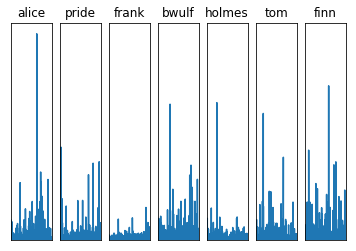

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

x = np.arange(len(all_words)) + 1
books = list(counts.keys())

for i in range(tfidf.shape[0]):
    book_tfidf = tfidf[i]
    
    plt.subplot(1, 7, i + 1)
    plt.plot(x, book_tfidf)
    plt.title(books[i])
    plt.ylim([0, 0.12])
    plt.xlim([0, x.shape[0] + 1])
    plt.xticks([])
    plt.yticks([])

(I know those histograms are super-smooshed; I'm sorry about that, only so much room on these slides!)

But the point of that exercise was to show that you can
 1. Put seven wildly different books on a level playing field,
 2. Directly compare them using a (preprocessed, TF-IDF -based) bag-of-words model

Are there any two histograms above that kinda-sorta-maybe look "similar"-ish? Oddly, *Frankenstein* and *Sherlock Holmes* appear to have a similar pattern; so do *Tom Sawyer* and *Huckleberry Finn* (perhaps not surprisingly, since they were written by the same author!).

This "similarity" or "difference" is the foundation for modern recommendation algorithms (e.g., Amazon, Netflix, Etsy, etc)--if you really liked *Tom Sawyer*, Amazon would know it's similar in content to *Huckleberry Finn* and recommend it to you!

One final bit of introspective magic: the above histograms are great, but they don't really give us a good intuition for what's really going on in these books.

Ever seen a word cloud before?

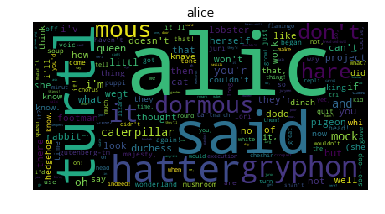

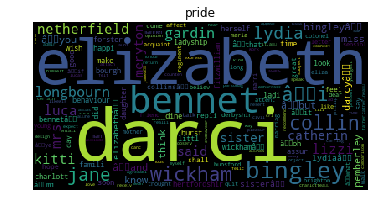

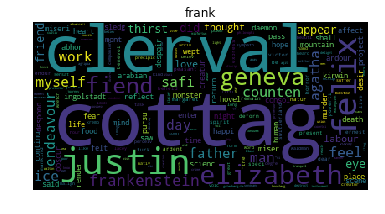

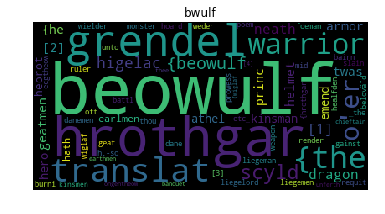

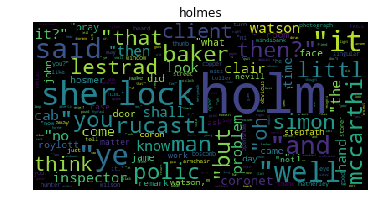

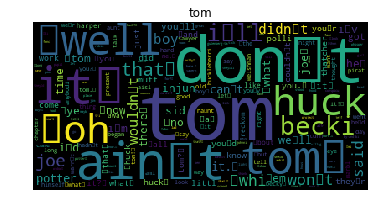

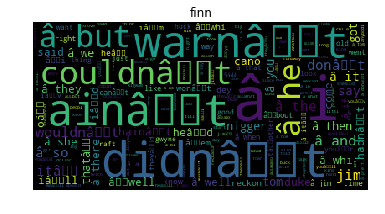

In [23]:
from wordcloud import WordCloud

for i in range(tfidf.shape[0]):
    book_tfidf = tfidf[i]
    freqs = {word: book_tfidf[j] for j, word in enumerate(all_words) if book_tfidf[j] > 0}
    wc = WordCloud().generate_from_frequencies(freqs)

    #plt.subplot(2, 4, i + 1)
    plt.figure(i)
    plt.imshow(wc)
    plt.title(books[i])
    plt.axis("off")

(if you're reading these slides as HTML, I'm sorry the figures get cut-off; either use the `ipynb` or `pdf` links on the course website's lecture schedule and view them that way instead to see all the wordcloud awesomeness!)

# Review Questions

Some questions to discuss and consider:

1: There are many machine learning algorithms that rely on the probability of a single word, $P(w)$, under some condition (e.g. the probability of a word in a conservative or liberal blog). Explain what this would involve.

2: So far we've considered only nonzero word counts. When you combine all the unique words in a collection of documents together, it's possible (even likely) that quite a few of the words will have counts of 0 in some of the documents. Why is this? What problems might this cause for the later analyses?

3: Another point we haven't even touched on, but which can really generate very powerful features, is the inclusion of $n$-grams. If you consider $n = 1$ to be the case of individual words as we've used them throughout the last two lectures, with $n = 2$ we instead consider a single "token" to be every sequence of 2 consecutive words. What advantages and disadvantages would this approach have (e.g. $n = 2$, or *bigrams*), over using single words ($n = 1$, or *unigrams*)?

## Course Administrivia

 - **How is Assignment 9 going?** Post any questions to the Slack `#questions` channel!

 - **Assignment 10 will be out tomorrow,** the final homework assignment!

## Additional Resources

 1. Grus, Joel. *Data Science from Scratch*, Chapter 9. 2015. ISBN-13: 978-1491901427
 2. Saha, Amit. *Doing Math with Python*, Chapter 3. 2015. ISBN-13: 978-1593276409
 3. Richert, Willi and Coelho, Luis Pedro. *Building Machine Learning Systems with Python*, Chapter 2. 2013. ISBN-13: 978-1782161400